# Feature Engineering

En este notebook aplicamos técnicas avanzadas de procesamiento de señales a los segmentos ya extraídos
en el Notebook de Exploración. El objetivo es generar un dataset tabular enriquecido mediante features
espectrales y tiempo-frecuencia provenientes de:

- Transformada de Fourier (FFT)
- Convolución con kernels
- Transformada Local Coseno (LCT)
- HRV y features temporales preexistentes

Con estos features construiremos un dataset robusto que servirá como insumo para los modelos de clasificación.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import sys
from pathlib import Path
import seaborn as sns
import warnings

BASE_DIR = Path(".." ).resolve()
SRC_DIR = BASE_DIR / "src"
for path in (BASE_DIR, SRC_DIR):
    if str(path) not in sys.path:
        sys.path.append(str(path))

warnings.filterwarnings("ignore")

from src.preprocessing import cortar_segmento, fft_features, conv_features, lct_features, cargar_senales_sujeto, generar_segmentos_ventana

In [17]:
DATA_DIR = BASE_DIR / "data"

env_override = os.environ.get("WEARABLE_DATASET_DIR")
if env_override:
    DATASET_DIR = Path(env_override).expanduser().resolve()
else:
    DATASET_DIR = DATA_DIR / "wearable-device-dataset-from-induced-stress-and-structured-exercise-sessions-1.0.1"

In [18]:
segments_path = DATA_DIR / "segments_metadata.csv"
df_segments = pd.read_csv(segments_path)

In [19]:
df_segments['start_time'] = pd.to_numeric(df_segments['start_time'], errors='coerce')
df_segments['end_time'] = pd.to_numeric(df_segments['end_time'], errors='coerce')

In [20]:
feature_rows = []
sujeto_cache = {}
errores_segmento = 0
segmentos_vacios = 0

for (condition, subject_id), group in df_segments.groupby(['condition', 'subject_id']):
    
    sujeto_key = f"{condition}_{subject_id}"
    
    if sujeto_key not in sujeto_cache:
        senales = cargar_senales_sujeto(condition, subject_id)
        if senales is None:
            errores_segmento += len(group)
            continue
        sujeto_cache[sujeto_key] = senales
    else:
        senales = sujeto_cache[sujeto_key]
    
    segmentos = generar_segmentos_ventana(senales['tags'], window_size=60, overlap=0)
    
    if len(segmentos) != len(group):
        print(f"{subject_id}: metadata tiene {len(group)} segmentos, tags generan {len(segmentos)}")
    
    EDA = senales['EDA']
    BVP = senales['BVP']
    TEMP = senales['TEMP']
    ACC = senales['ACC']
    eda_freq = senales['eda_freq']
    bvp_freq = senales['bvp_freq']
    temp_freq = senales['temp_freq']
    acc_freq = senales['acc_freq']
    
    for idx, (meta_idx, meta_row) in enumerate(group.iterrows()):
        if idx >= len(segmentos):
            break
            
        seg_info = segmentos[idx]
        start_time = seg_info['start_time']
        end_time = seg_info['end_time']
        label = meta_row['label']
        
        eda_seg = cortar_segmento(EDA, start_time, end_time)
        bvp_seg = cortar_segmento(BVP, start_time, end_time)
        acc_seg = cortar_segmento(ACC, start_time, end_time)
        temp_seg = cortar_segmento(TEMP, start_time, end_time)
        
        if len(eda_seg) == 0:
            segmentos_vacios += 1
            continue
        
        seg = {}
        seg["subject_id"] = subject_id
        seg["condition"] = condition
        seg["label"] = label
        
        # EXTRACCION DE FEATURES
        seg.update({f"EDA_{k}":v for k,v in fft_features(eda_seg, eda_freq).items()})
        seg.update({f"EDA_{k}":v for k,v in conv_features(eda_seg).items()})
        seg.update({f"EDA_{k}":v for k,v in lct_features(eda_seg).items()})
        
        seg.update({f"BVP_{k}":v for k,v in fft_features(bvp_seg, bvp_freq).items()})
        seg.update({f"BVP_{k}":v for k,v in conv_features(bvp_seg).items()})
        seg.update({f"BVP_{k}":v for k,v in lct_features(bvp_seg).items()})
        
        seg.update({f"ACC_{k}":v for k,v in fft_features(acc_seg, acc_freq).items()})
        seg.update({f"ACC_{k}":v for k,v in conv_features(acc_seg).items()})
        seg.update({f"ACC_{k}":v for k,v in lct_features(acc_seg).items()})
        
        seg.update({f"TEMP_{k}":v for k,v in fft_features(temp_seg, temp_freq).items()})
        seg.update({f"TEMP_{k}":v for k,v in conv_features(temp_seg).items()})
        seg.update({f"TEMP_{k}":v for k,v in lct_features(temp_seg).items()})
        
        feature_rows.append(seg)

df_features_adv = pd.DataFrame(feature_rows)

print(f"Segmentos procesados: {len(df_features_adv)}")
print(f"Segmentos vacíos (descartados): {segmentos_vacios}")
print(f"Sujetos con errores: {errores_segmento}")
print(f"Columnas totales: {len(df_features_adv.columns)}")
print(f"\nDistribución de labels:")
print(df_features_adv['label'].value_counts())

nan_count = df_features_adv.isna().sum().sum()
print(f"Total de NaNs: {nan_count}")
if nan_count > 0:
    print(f"    Columnas con NaNs:")
    nan_cols = df_features_adv.columns[df_features_adv.isna().any()].tolist()
    for col in nan_cols[:5]:
        n = df_features_adv[col].isna().sum()
        print(f"      {col}: {n} ({100*n/len(df_features_adv):.1f}%)")

df_features_adv.head()


Segmentos procesados: 1976
Segmentos vacíos (descartados): 0
Sujetos con errores: 0
Columnas totales: 43

Distribución de labels:
label
rest         634
aerobic      611
stress       267
anaerobic    236
unknown      228
Name: count, dtype: int64
Total de NaNs: 0


,subject_id,condition,label,EDA_fft_dom,EDA_fft_energy,EDA_fft_centroid,EDA_fft_entropy,EDA_conv_d1,EDA_conv_d2,EDA_conv_gauss,...,TEMP_fft_dom,TEMP_fft_energy,TEMP_fft_centroid,TEMP_fft_entropy,TEMP_conv_d1,TEMP_conv_d2,TEMP_conv_gauss,TEMP_lct_mean,TEMP_lct_std,TEMP_lct_energy
0,S01,AEROBIC,rest,1.360996,0.000250,1.046346,3.364931,0.049196,0.103519,3500.676911,...,0.016598,0.050957,0.079138,1.247681,1252.4675,2493.6358,8.890833e+07,2.286758,35.254542,300794.9849
1,S01,AEROBIC,rest,1.377593,0.003347,1.024968,4.468163,0.077482,0.179818,3638.097041,...,0.016598,0.051885,0.060726,0.949111,1241.1709,2468.2898,8.789513e+07,2.274590,35.053597,297376.7441
2,S01,AEROBIC,aerobic,1.410788,0.000280,1.065241,3.274031,0.058602,0.121120,4076.337919,...,0.016598,0.046257,0.068437,0.974821,1207.5757,2399.9094,8.556679e+07,2.243336,34.586253,289499.1857
3,S01,AEROBIC,aerobic,1.377593,0.000221,1.006679,3.438913,0.059334,0.125183,4253.976650,...,0.016598,0.045503,0.105042,1.524444,1193.7217,2379.1654,8.466945e+07,2.232437,34.404073,286458.3841
4,S01,AEROBIC,aerobic,0.016598,0.000413,0.614235,2.594450,0.068261,0.145467,4840.272870,...,0.016598,0.031343,0.074762,1.167125,1170.3417,2331.1238,8.301671e+07,2.210245,34.066710,280867.6409


In [21]:
output_path = DATA_DIR / "dataset_features_advanced.csv"
df_features_adv.to_csv(output_path, index=False)
print(f"Guardado como {output_path}")

Guardado como /Users/sofiaramos/Desktop/ML/TPF/data/dataset_features_advanced.csv


## Análisis Exploratorio de Features

Antes de aplicar reducción dimensional, analizamos la calidad de los features extraídos y verificamos la presencia de correlaciones que justifiquen la necesidad de PCA.

In [22]:
X = df_features_adv.drop(['subject_id', 'condition', 'label'], axis=1)
y = df_features_adv['label']

print(f"Dataset de features:")
print(f"  Shape: {X.shape}")
print(f"  Número de features: {X.shape[1]}")
print(f"  Número de muestras: {X.shape[0]}")

Dataset de features:
  Shape: (1976, 40)
  Número de features: 40
  Número de muestras: 1976


No se requiere imputacion, el dataset no tiene NaNs.

### Análisis de Correlación entre Features

Analizamos las correlaciones entre features espectrales para identificar redundancia y ver si es necesaria la aplicacion de PCA.

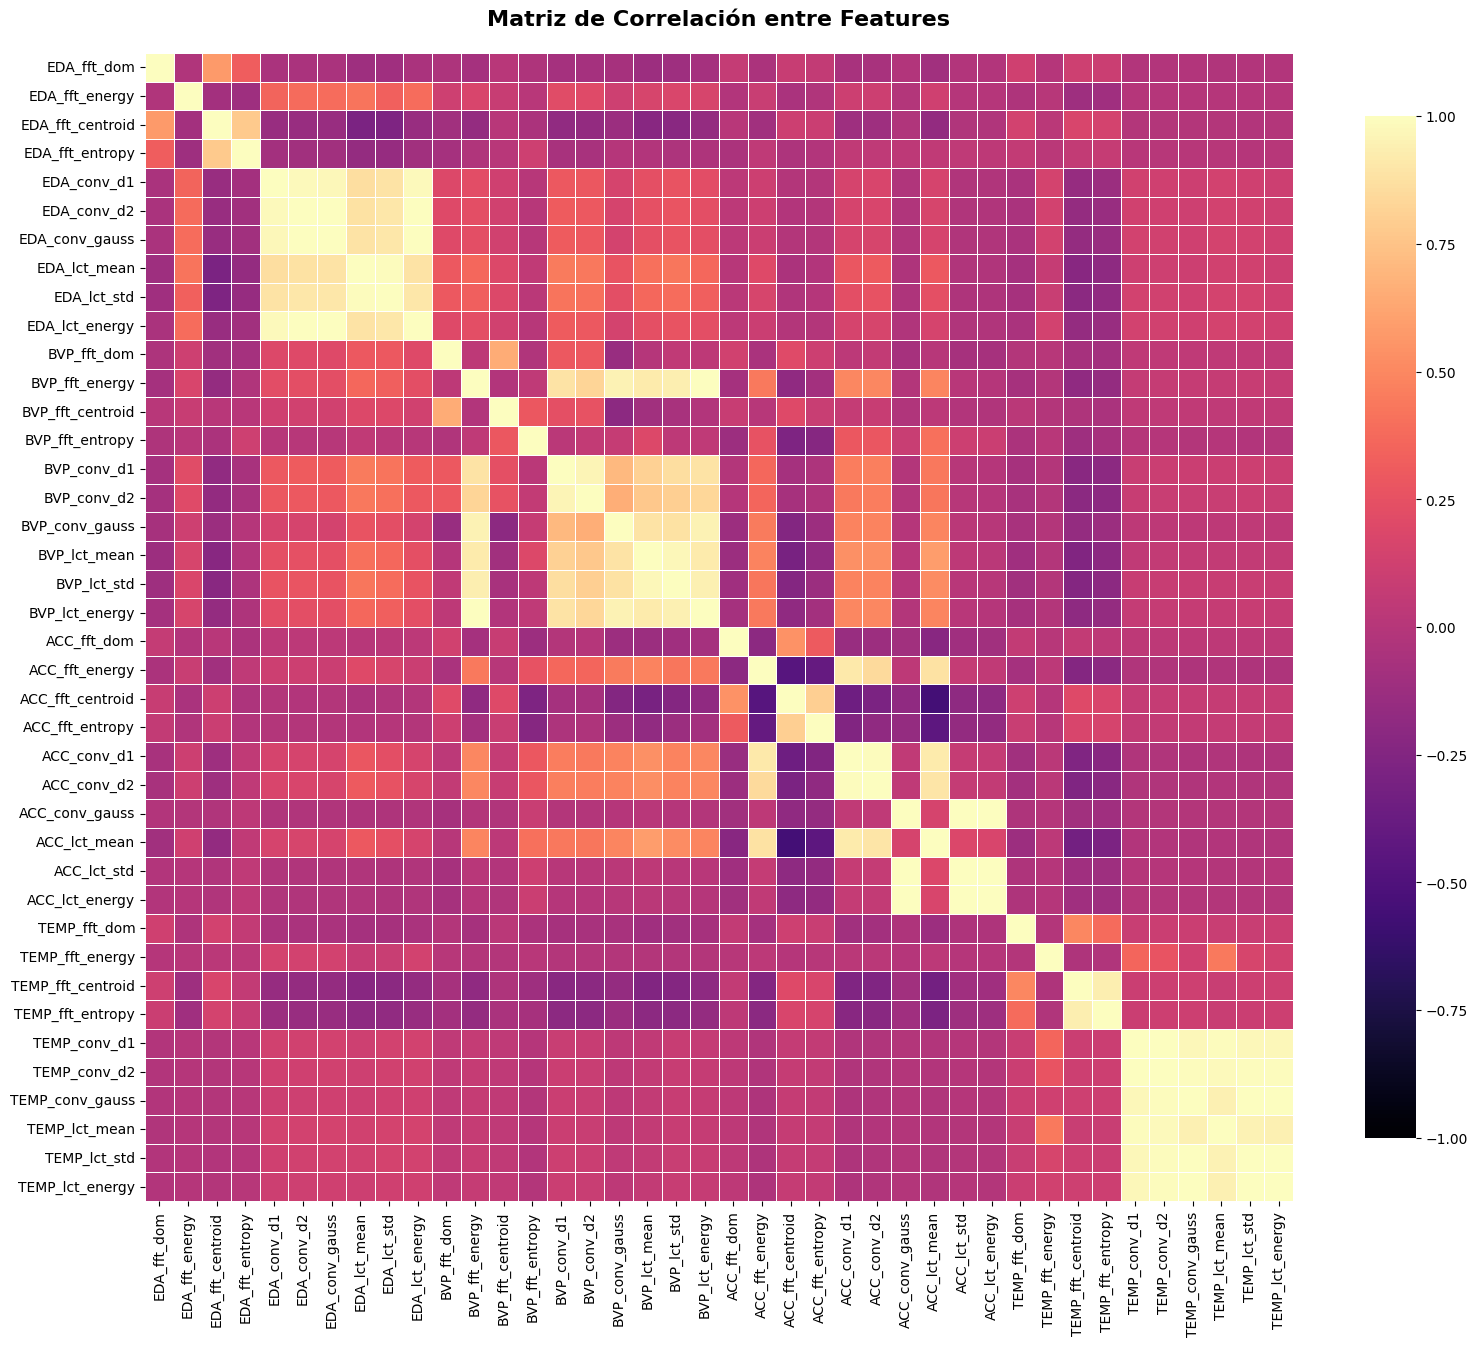

In [23]:
correlation_matrix = X.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            cmap='magma', 
            center=0, 
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

FEATURES ALTAMENTE CORRELACIONADOS (|r| > 0.9)
 Total de pares: 40

          feature_1        feature_2  correlation
36  TEMP_conv_gauss  TEMP_lct_energy     0.999997
6    EDA_conv_gauss   EDA_lct_energy     0.999995
22   ACC_conv_gauss   ACC_lct_energy     0.999878
23      ACC_lct_std   ACC_lct_energy     0.998652
21   ACC_conv_gauss      ACC_lct_std     0.998324
12   BVP_fft_energy   BVP_lct_energy     0.998080
39     TEMP_lct_std  TEMP_lct_energy     0.997557
35  TEMP_conv_gauss     TEMP_lct_std     0.997480
4       EDA_conv_d2   EDA_lct_energy     0.996156
3       EDA_conv_d2   EDA_conv_gauss     0.995883
25     TEMP_conv_d1     TEMP_conv_d2     0.994309
27     TEMP_conv_d1    TEMP_lct_mean     0.991024
32     TEMP_conv_d2     TEMP_lct_std     0.990483
33     TEMP_conv_d2  TEMP_lct_energy     0.988952
30     TEMP_conv_d2  TEMP_conv_gauss     0.988614
19      ACC_conv_d1      ACC_conv_d2     0.988589
7      EDA_lct_mean      EDA_lct_std     0.987533
0       EDA_conv_d1      EDA_con

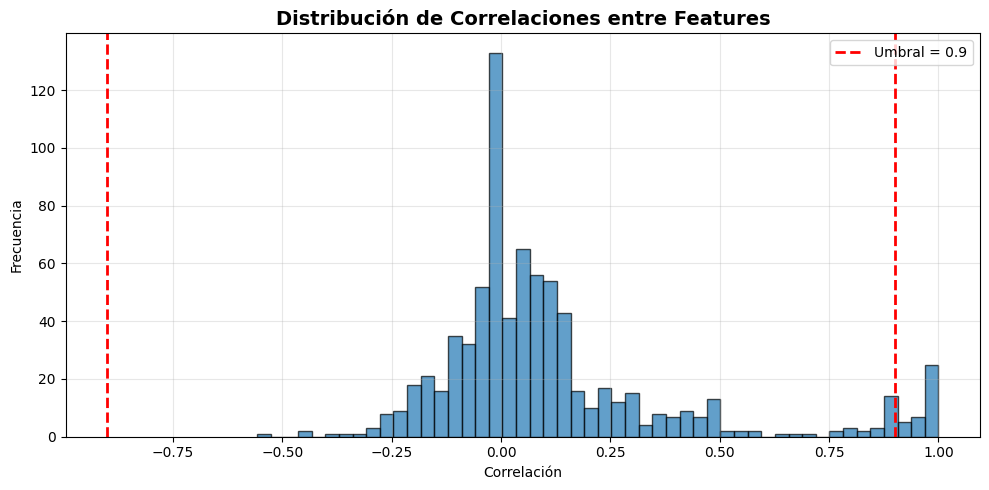

In [24]:
threshold = 0.9
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append({
                'feature_1': correlation_matrix.columns[i],
                'feature_2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

print(f"FEATURES ALTAMENTE CORRELACIONADOS (|r| > {threshold})")
print(f" Total de pares: {len(high_corr_pairs)}\n")

if len(high_corr_pairs) > 0:
    df_high_corr = pd.DataFrame(high_corr_pairs)
    df_high_corr = df_high_corr.sort_values('correlation', ascending=False, key=abs)
    
    print(df_high_corr.head(20))
    
    print(f"\nEstadísticas:")
    print(f"  Correlación promedio: {df_high_corr['correlation'].abs().mean():.3f}")
    print(f"  Correlación máxima: {df_high_corr['correlation'].abs().max():.3f}")
    print(f"  Correlación mínima: {df_high_corr['correlation'].abs().min():.3f}")
else:
    print("No se encontraron features con correlación > 0.9")

plt.figure(figsize=(10, 5))
plt.hist(correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)], 
         bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Correlación')
plt.ylabel('Frecuencia')
plt.title('Distribución de Correlaciones entre Features', fontsize=14, fontweight='bold')
plt.axvline(x=threshold, color='r', linestyle='--', linewidth=2, label=f'Umbral = {threshold}')
plt.axvline(x=-threshold, color='r', linestyle='--', linewidth=2)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
signal_types = ['EDA', 'BVP', 'ACC', 'TEMP']

print(f"ANÁLISIS DE REDUNDANCIA POR TIPO DE SEÑAL:")

for signal in signal_types:
    signal_features = [col for col in X.columns if col.startswith(signal)]
    
    if len(signal_features) > 1:
        signal_corr = correlation_matrix.loc[signal_features, signal_features]
        
        mask = np.triu(np.ones_like(signal_corr, dtype=bool), k=1)
        avg_corr = signal_corr.where(mask).abs().mean().mean()
        
        high_corr_count = (signal_corr.where(mask).abs() > threshold).sum().sum()
        
        print(f"{signal}:")
        print(f"  Número de features: {len(signal_features)}")
        print(f"  Correlación promedio: {avg_corr:.3f}")
        print(f"  Pares con |r| > {threshold}: {high_corr_count}")
        print()

ANÁLISIS DE REDUNDANCIA POR TIPO DE SEÑAL:
EDA:
  Número de features: 10
  Correlación promedio: 0.376
  Pares con |r| > 0.9: 9

BVP:
  Número de features: 10
  Correlación promedio: 0.390
  Pares con |r| > 0.9: 9

ACC:
  Número de features: 10
  Correlación promedio: 0.368
  Pares con |r| > 0.9: 6

TEMP:
  Número de features: 10
  Correlación promedio: 0.361
  Pares con |r| > 0.9: 16



La presencia de correlaciones altas (40 pares > 0.99) justifica la aplicación de PCA para eliminar redundancia y reducir dimensionalidad.

## Reducción Dimensional con PCA

Dado que observamos alta correlación entre features espectrales (especialmente dentro de cada tipo de señal), aplicamos PCA para:
1. Eliminar redundancia entre features correlacionados
2. Reducir la dimensionalidad manteniendo la mayor varianza posible
3. Obtener representaciones más compactas para los modelos de clasificación

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features estandarizados:")
print(f"  Shape: {X_scaled.shape}")
print(f"  Media: {X_scaled.mean():.6f}")
print(f"  Desviación estándar: {X_scaled.std():.6f}")

Features estandarizados:
  Shape: (1976, 40)
  Media: 0.000000
  Desviación estándar: 1.000000


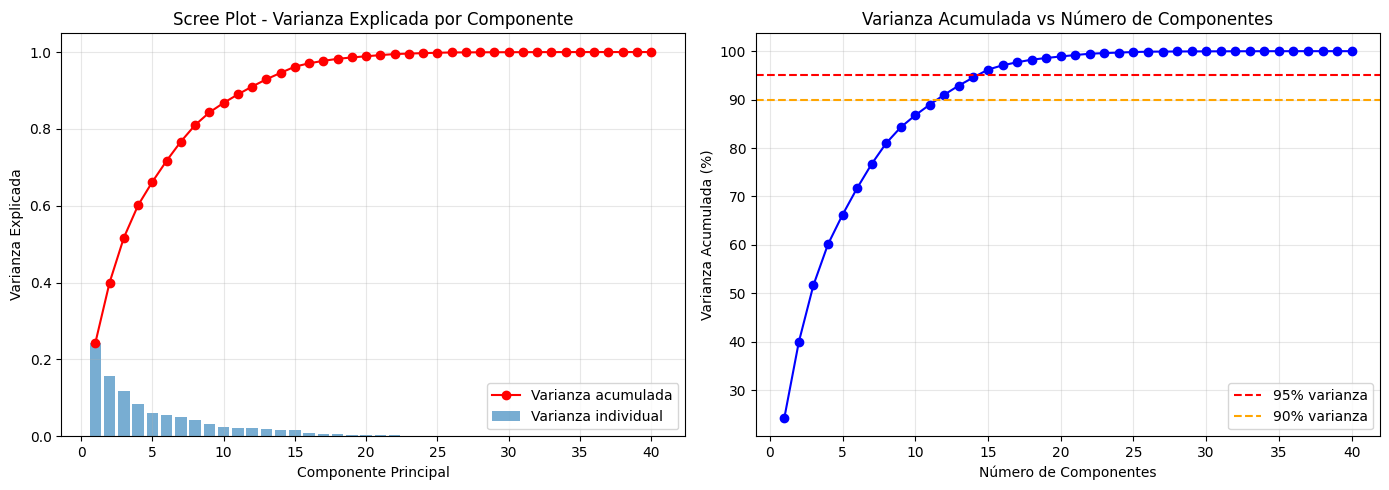

Componentes necesarios para 90% varianza: 12
Componentes necesarios para 95% varianza: 15
Componentes necesarios para 99% varianza: 21


In [27]:
pca_full = PCA()
pca_full.fit(X_scaled)

var_exp = pca_full.explained_variance_ratio_
var_cum = np.cumsum(var_exp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(range(1, len(var_exp)+1), var_exp, alpha=0.6, label='Varianza individual')
ax1.plot(range(1, len(var_exp)+1), var_cum, 'r-', marker='o', label='Varianza acumulada')
ax1.set_xlabel('Componente Principal')
ax1.set_ylabel('Varianza Explicada')
ax1.set_title('Scree Plot - Varianza Explicada por Componente')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(range(1, len(var_cum)+1), var_cum * 100, 'b-', marker='o')
ax2.axhline(y=95, color='r', linestyle='--', label='95% varianza')
ax2.axhline(y=90, color='orange', linestyle='--', label='90% varianza')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Acumulada (%)')
ax2.set_title('Varianza Acumulada vs Número de Componentes')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

for threshold in [0.90, 0.95, 0.99]:
    n_comp = np.argmax(var_cum >= threshold) + 1
    print(f"Componentes necesarios para {threshold*100:.0f}% varianza: {n_comp}")

In [28]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"\nReducción dimensional:")
print(f"  Features originales: {X.shape[1]}")
print(f"  Componentes principales: {X_pca.shape[1]}")
print(f"  Reducción: {100*(1 - X_pca.shape[1]/X.shape[1]):.1f}%")
print(f"  Varianza retenida: {pca.explained_variance_ratio_.sum()*100:.2f}%")

pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_cols)

df_pca['subject_id'] = df_features_adv['subject_id'].values
df_pca['condition'] = df_features_adv['condition'].values
df_pca['label'] = df_features_adv['label'].values

df_pca.head()


Reducción dimensional:
  Features originales: 40
  Componentes principales: 15
  Reducción: 62.5%
  Varianza retenida: 96.20%


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,subject_id,condition,label
0,-2.802515,0.416595,0.447311,-0.778997,-0.172262,3.961527,3.762902,-3.978499,1.133894,-0.935717,-0.694513,1.096536,2.942551,-0.623955,2.788694,S01,AEROBIC,rest
1,-2.667479,0.264759,0.289643,-0.635830,-0.437806,4.351127,3.985263,-4.479060,1.093052,-0.990134,-0.700258,0.920977,2.804761,-0.523640,2.285475,S01,AEROBIC,rest
2,-2.724604,0.326112,0.497853,-0.670842,-0.323801,3.958479,4.116056,-4.070654,1.122540,-1.026768,-1.412149,0.814580,2.989845,-0.613822,2.877699,S01,AEROBIC,aerobic
3,-2.679033,0.309246,0.336721,-0.718619,-0.419908,4.161223,3.844654,-3.545503,1.238571,-0.939650,-0.747925,1.052138,2.915459,-0.840076,2.850309,S01,AEROBIC,aerobic
4,-2.124242,0.041670,0.445970,0.145366,-0.476846,-0.041640,2.480029,-1.433781,0.141620,-0.098022,0.178023,0.099919,-0.250990,0.481163,-0.635834,S01,AEROBIC,aerobic


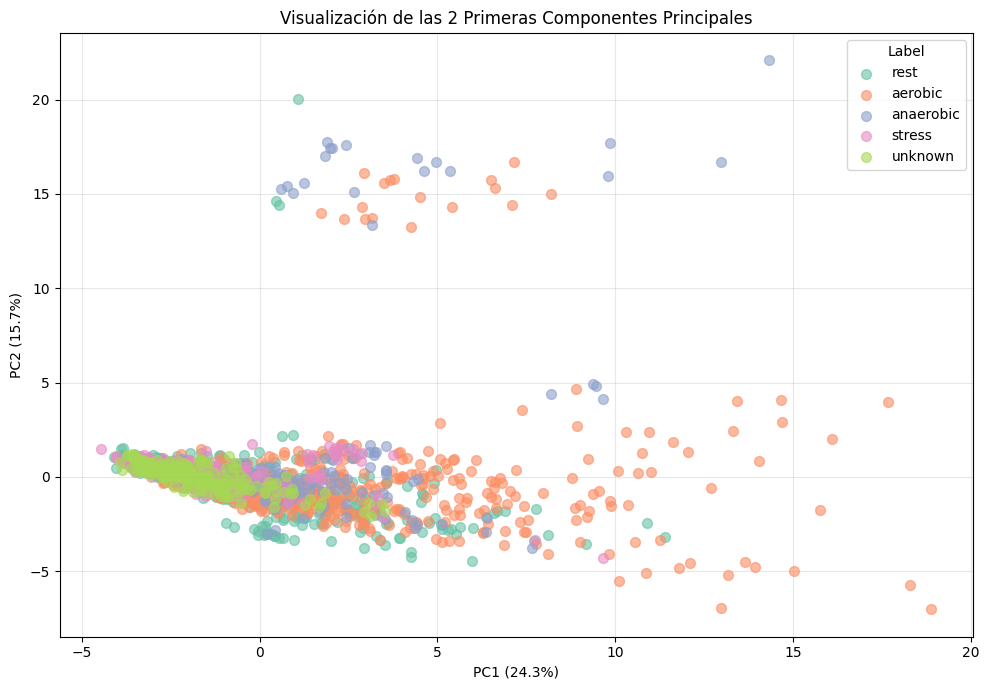

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))

labels_unique = df_pca['label'].unique()
colors = plt.cm.Set2(range(len(labels_unique)))

for label, color in zip(labels_unique, colors):
    mask = df_pca['label'] == label
    ax.scatter(df_pca.loc[mask, 'PC1'], 
               df_pca.loc[mask, 'PC2'],
               c=[color], label=label, alpha=0.6, s=50)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('Visualización de las 2 Primeras Componentes Principales')
ax.legend(title='Label')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
output_pca = DATA_DIR / "dataset_features_pca.csv"
df_pca.to_csv(output_pca, index=False)

print(f"Dataset con PCA guardado exitosamente")
print(f"  Ubicación: {output_pca}")
print(f"  Shape: {df_pca.shape}")
print(f"  Columnas: {len(df_pca.columns)}")
print(f"    - Componentes principales: {len([c for c in df_pca.columns if c.startswith('PC')])}")
print(f"    - Metadata: subject_id, condition, label")

Dataset con PCA guardado exitosamente
  Ubicación: /Users/sofiaramos/Desktop/ML/TPF/data/dataset_features_pca.csv
  Shape: (1976, 18)
  Columnas: 18
    - Componentes principales: 15
    - Metadata: subject_id, condition, label
